In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mmmai-regist-data/MR-ART-Regist/sub-654178/anat/sub-654178_acq-headmotion1_T1w.nii
/kaggle/input/mmmai-regist-data/MR-ART-Regist/sub-654178/anat/sub-654178_acq-headmotion2_T1w.nii
/kaggle/input/mmmai-regist-data/MR-ART-Regist/sub-654178/anat/sub-654178_acq-standard_T1w.nii
/kaggle/input/mmmai-regist-data/MR-ART-Regist/sub-228373/anat/sub-228373_acq-headmotion2_T1w.nii
/kaggle/input/mmmai-regist-data/MR-ART-Regist/sub-228373/anat/sub-228373_acq-headmotion1_T1w.nii
/kaggle/input/mmmai-regist-data/MR-ART-Regist/sub-228373/anat/sub-228373_acq-standard_T1w.nii
/kaggle/input/mmmai-regist-data/MR-ART-Regist/sub-945122/anat/sub-945122_acq-headmotion1_T1w.nii
/kaggle/input/mmmai-regist-data/MR-ART-Regist/sub-945122/anat/sub-945122_acq-standard_T1w.nii
/kaggle/input/mmmai-regist-data/MR-ART-Regist/sub-945122/anat/sub-945122_acq-headmotion2_T1w.nii
/kaggle/input/mmmai-regist-data/MR-ART-Regist/sub-927452/anat/sub-927452_acq-headmotion1_T1w.nii
/kaggle/input/mmmai-regist-data/MR-ART-

In [2]:
import matplotlib.pyplot as plt
import os
import subprocess
import nibabel as nib
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from skimage import exposure
from math import ceil
import random

In [24]:
import matplotlib.pyplot as plt
import os
import subprocess
import nibabel as nib
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from skimage import exposure
from math import ceil
import random

class MotionArtifactDataset(Dataset):
    def __init__(self, data_path, subjects, batch_size):
        self.data_path = data_path
        self.subjects = subjects
        self.batch_size = batch_size
        self.samples = self.generate_samples()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

    def generate_samples(self):
        samples = []
        for subject in self.subjects:
            for i in range(2):
                pathes = self.get_nifti_path(subject, str(i + 1))
                free, motion = self.get_paired_volumes(pathes)

                if motion is not None:
                    number_of_batches = int(motion.shape[0] // self.batch_size)

                    for batch_idx in range(number_of_batches):
                        start_idx = batch_idx * self.batch_size + 1
                        end_idx = (batch_idx + 1) * self.batch_size + 1
                        free_batch = free[start_idx:end_idx]
                        motion_batch = motion[start_idx:end_idx]
                        motion_before_batch = motion[batch_idx * self.batch_size:(batch_idx + 1) * self.batch_size]
                        motion_after_batch = motion[batch_idx * self.batch_size + 2:(batch_idx + 1) * self.batch_size + 2]

                        samples.append ((motion_batch, free_batch))
        return samples
                                
#                 samples.append(((motion[:-2], motion[1:-1], motion[2:]), free))
#                 print(samples)

#         return samples

    def get_nifti_path(self, subject, motion_severity):
        ref_path_stand = f'{self.data_path}/{subject}/anat/{subject}_acq-standard_T1w.nii'
#         select_path_stand = subprocess.run(['ls', ref_path_stand], capture_output=True, text=True).stdout.replace("\n", "")

        ref_path_motion = f'{self.data_path}/{subject}/anat/{subject}_acq-headmotion{motion_severity}_T1w.nii'
#         select_path_motion = subprocess.run(['ls', ref_path_motion], capture_output=True, text=True).stdout.replace("\n", "")

        return [ref_path_stand, ref_path_motion]

    def get_paired_volumes(self, path):
        if os.path.exists(path[0]) and os.path.exists(path[1]):
            free_data = nib.load(path[0]).get_fdata()
            free_data = exposure.rescale_intensity(free_data, out_range=(-1.0, 1.0))
            motion_data = nib.load(path[1]).get_fdata()
            motion_data = exposure.rescale_intensity(motion_data, out_range=(-1.0, 1.0))
            return torch.Tensor(free_data), torch.Tensor(motion_data)
        else:
            return None, None


class MotionArtifactDataLoader:
    def __init__(self, data_path, split_ratio, batch_size):
        self.data_path = data_path
        self.split_ratio = split_ratio
        self.all_subjects = None
        self.subjects_lists = []
        self.labels = {'train': 0, 'test': 1, 'validation': 2}
        self.size = [0, 0, 0]
        self.batch_size = batch_size

        
    def list_subjects(self):
        subjects = os.listdir(self.data_path)
        subjects = [item for item in subjects if item.startswith('sub')]
        self.all_subjects = subjects

    def split_data(self):
        self.list_subjects()
        if ceil(sum(self.split_ratio)) == 1 and len(self.split_ratio) <= 3:
            self.split_ratio.insert(0, 0)
            cumulative_sum = [sum(self.split_ratio[:i + 1]) for i in range(len(self.split_ratio))]
            number_of_subjects = len(self.all_subjects)

            for i in range(1, len(self.split_ratio)):
                self.subjects_lists.append(
                    self.all_subjects[int(round(cumulative_sum[i - 1] * number_of_subjects)):int(
                        round(cumulative_sum[i] * number_of_subjects))])

                self.size[i - 1] = len(self.subjects_lists[i - 1]) * 2 * 190

                if i - 1 == 0:
                    self.size[i - 1] -= 8 * 2 * 190
        else:
            print("The Summation of ratios is not equal to 1")

    def generator(self, mode):
        subjects = self.subjects_lists[self.labels[mode]]

        transform = transforms.Compose([
            transforms.ToTensor(),
        ])

        dataset = MotionArtifactDataset(self.data_path, subjects, self.batch_size)
        dataloader = DataLoader(dataset, shuffle=True)

        return dataloader


# Example usage:
data_path = "/kaggle/input/mmmai-regist-data/MR-ART-Regist"
split_ratio = [0.7, 0.2, 0.1]
# split_ratio = [0.01, 0.98, 0.01]
batch_size = config['batch_size']

data_loader = MotionArtifactDataLoader(data_path, split_ratio, batch_size)
data_loader.split_data()

# train_dataloader = data_loader.generator('train')
# train_dataloader = torch.load(file_path)
test_dataloader = data_loader.generator('test')
# validation_dataloader = data_loader.generator('validation')

In [4]:
config = {
    'image_save_iter': 10000,       # How often do you want to save output images during training
    'image_display_iter': 1000,      # How often do you want to display output images during training
    'display_size': 16,             # How many images do you want to display each time
    'snapshot_save_iter': 24544,    # How often do you want to save trained models
    'log_iter': 10,                 # How often do you want to log the training stats
    
    # Optimization options
    'max_iter': 245440,            # Maximum number of training iterations
    'batch_size': 1,                # Batch size
    'weight_decay': 0.0001,         # Weight decay
    'beta1': 0.5,                   # Adam parameter
    'beta2': 0.999,                 # Adam parameter
    'init': 'kaiming',              # Initialization [gaussian/kaiming/xavier/orthogonal]
    'lr': 0.0001,                   # Initial learning rate
    'lr_policy': 'step',            # Learning rate scheduler
    'step_size': 100000,            # How often to decay learning rate
    'gamma': 0.5,                   # How much to decay learning rate
    'gan_w': 1,                     # Weight of adversarial loss
    'recon_x_w': 10,                # Weight of image reconstruction loss
    'recon_h_w': 0,                 # Weight of hidden reconstruction loss
    'recon_kl_w': 0.01,             # Weight of KL loss for reconstruction
    'recon_x_cyc_w': 10,            # Weight of cycle consistency loss
    'recon_kl_cyc_w': 0.01,         # Weight of KL loss for cycle consistency
    'vgg_w': 0,                     # Weight of domain-invariant perceptual loss
    
    # Model options
    'gen': {
        'dim': 64,                  # Number of filters in the bottommost layer
        'activ': 'relu',            # Activation function [relu/lrelu/prelu/selu/tanh]
        'n_downsample': 2,          # Number of downsampling layers in content encoder
        'n_res': 4,                 # Number of residual blocks in content encoder/decoder
        'pad_type': 'reflect'       # Padding type [zero/reflect]
    },
    'dis': {
        'dim': 64,                  # Number of filters in the bottommost layer
        'norm': 'none',             # Normalization layer [none/bn/in/ln]
        'activ': 'lrelu',           # Activation function [relu/lrelu/prelu/selu/tanh]
        'n_layer': 4,               # Number of layers in D
        'gan_type': 'lsgan',        # GAN loss [lsgan/nsgan]
        'num_scales': 3,            # Number of scales
        'pad_type': 'reflect'       # Padding type [zero/reflect]
    },
    
    # Data options
    'input_dim_a': 1,                   # Number of image channels [1/3]
    'input_dim_b': 1,                   # Number of image channels [1/3]
    'num_workers': 8,                   # Number of data loading threads
    'new_size': 256,                    # First resize the shortest image side to this size
    'crop_image_height': 256,           # Random crop image of this height
    'crop_image_width': 256,            # Random crop image of this width
    'data_root': './datasets/edges2handbags/'  # Dataset folder location
}


In [5]:
"""
Copyright (C) 2018 NVIDIA Corporation.  All rights reserved.
Licensed under the CC BY-NC-SA 4.0 license (https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode).
"""
# from torch.utils.serialization import load_lua
# from torch.utils.data import DataLoader
# from networks import Vgg16
from torch.autograd import Variable
from torch.optim import lr_scheduler
from torchvision import transforms
# from data import ImageFilelist, ImageFolder
import torch
import os
import math
import torchvision.utils as vutils
import yaml
import numpy as np
import torch.nn.init as init
import time
# Methods
# get_all_data_loaders      : primary data loader interface (load trainA, testA, trainB, testB)
# get_data_loader_list      : list-based data loader
# get_data_loader_folder    : folder-based data loader
# get_config                : load yaml file
# eformat                   :
# write_2images             : save output image
# prepare_sub_folder        : create checkpoints and images folders for saving outputs
# write_one_row_html        : write one row of the html file for output images
# write_html                : create the html file.
# write_loss
# slerp
# get_slerp_interp
# get_model_list
# load_vgg16
# vgg_preprocess
# get_scheduler
# weights_init

def get_all_data_loaders(conf):
    batch_size = conf['batch_size']
    num_workers = conf['num_workers']
    if 'new_size' in conf:
        new_size_a = new_size_b = conf['new_size']
    else:
        new_size_a = conf['new_size_a']
        new_size_b = conf['new_size_b']
    height = conf['crop_image_height']
    width = conf['crop_image_width']

    if 'data_root' in conf:
        train_loader_a = get_data_loader_folder(os.path.join(conf['data_root'], 'trainA'), batch_size, True,
                                              new_size_a, height, width, num_workers, True)
        test_loader_a = get_data_loader_folder(os.path.join(conf['data_root'], 'testA'), batch_size, False,
                                             new_size_a, new_size_a, new_size_a, num_workers, True)
        train_loader_b = get_data_loader_folder(os.path.join(conf['data_root'], 'trainB'), batch_size, True,
                                              new_size_b, height, width, num_workers, True)
        test_loader_b = get_data_loader_folder(os.path.join(conf['data_root'], 'testB'), batch_size, False,
                                             new_size_b, new_size_b, new_size_b, num_workers, True)
    else:
        train_loader_a = get_data_loader_list(conf['data_folder_train_a'], conf['data_list_train_a'], batch_size, True,
                                                new_size_a, height, width, num_workers, True)
        test_loader_a = get_data_loader_list(conf['data_folder_test_a'], conf['data_list_test_a'], batch_size, False,
                                                new_size_a, new_size_a, new_size_a, num_workers, True)
        train_loader_b = get_data_loader_list(conf['data_folder_train_b'], conf['data_list_train_b'], batch_size, True,
                                                new_size_b, height, width, num_workers, True)
        test_loader_b = get_data_loader_list(conf['data_folder_test_b'], conf['data_list_test_b'], batch_size, False,
                                                new_size_b, new_size_b, new_size_b, num_workers, True)
    return train_loader_a, train_loader_b, test_loader_a, test_loader_b


def get_data_loader_list(root, file_list, batch_size, train, new_size=None,
                           height=256, width=256, num_workers=4, crop=True):
    transform_list = [transforms.ToTensor(),
                      transforms.Normalize((0.5, 0.5, 0.5),
                                           (0.5, 0.5, 0.5))]
    transform_list = [transforms.RandomCrop((height, width))] + transform_list if crop else transform_list
    transform_list = [transforms.Resize(new_size)] + transform_list if new_size is not None else transform_list
    transform_list = [transforms.RandomHorizontalFlip()] + transform_list if train else transform_list
    transform = transforms.Compose(transform_list)
    dataset = ImageFilelist(root, file_list, transform=transform)
    loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=train, drop_last=True, num_workers=num_workers)
    return loader

def get_data_loader_folder(input_folder, batch_size, train, new_size=None,
                           height=256, width=256, num_workers=4, crop=True):
    transform_list = [transforms.ToTensor(),
                      transforms.Normalize((0.5, 0.5, 0.5),
                                           (0.5, 0.5, 0.5))]
    transform_list = [transforms.RandomCrop((height, width))] + transform_list if crop else transform_list
    transform_list = [transforms.Resize(new_size)] + transform_list if new_size is not None else transform_list
    transform_list = [transforms.RandomHorizontalFlip()] + transform_list if train else transform_list
    transform = transforms.Compose(transform_list)
    dataset = ImageFolder(input_folder, transform=transform)
    loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=train, drop_last=True, num_workers=num_workers)
    return loader


def get_config(config):
    with open(config, 'r') as stream:
        return yaml.load(stream)


def eformat(f, prec):
    s = "%.*e"%(prec, f)
    mantissa, exp = s.split('e')
    # add 1 to digits as 1 is taken by sign +/-
    return "%se%d"%(mantissa, int(exp))


def __write_images(image_outputs, display_image_num, file_name):
    image_outputs = [images.expand(-1, 3, -1, -1) for images in image_outputs] # expand gray-scale images to 3 channels
    image_tensor = torch.cat([images[:display_image_num] for images in image_outputs], 0)
    image_grid = vutils.make_grid(image_tensor.data, nrow=display_image_num, padding=0, normalize=True)
    vutils.save_image(image_grid, file_name, nrow=1)


def write_2images(image_outputs, display_image_num, image_directory, postfix):
    n = len(image_outputs)
    __write_images(image_outputs[0:n//2], display_image_num, '%s/gen_a2b_%s.jpg' % (image_directory, postfix))
    __write_images(image_outputs[n//2:n], display_image_num, '%s/gen_b2a_%s.jpg' % (image_directory, postfix))


def prepare_sub_folder(output_directory):
    image_directory = os.path.join(output_directory, 'images')
    if not os.path.exists(image_directory):
        print("Creating directory: {}".format(image_directory))
        os.makedirs(image_directory)
    checkpoint_directory = os.path.join(output_directory, 'checkpoints')
    if not os.path.exists(checkpoint_directory):
        print("Creating directory: {}".format(checkpoint_directory))
        os.makedirs(checkpoint_directory)
    return checkpoint_directory, image_directory


def write_one_row_html(html_file, iterations, img_filename, all_size):
    html_file.write("<h3>iteration [%d] (%s)</h3>" % (iterations,img_filename.split('/')[-1]))
    html_file.write("""
        <p><a href="%s">
          <img src="%s" style="width:%dpx">
        </a><br>
        <p>
        """ % (img_filename, img_filename, all_size))
    return


def write_html(filename, iterations, image_save_iterations, image_directory, all_size=1536):
    html_file = open(filename, "w")
    html_file.write('''
    <!DOCTYPE html>
    <html>
    <head>
      <title>Experiment name = %s</title>
      <meta http-equiv="refresh" content="30">
    </head>
    <body>
    ''' % os.path.basename(filename))
    html_file.write("<h3>current</h3>")
    write_one_row_html(html_file, iterations, '%s/gen_a2b_train_current.jpg' % (image_directory), all_size)
    write_one_row_html(html_file, iterations, '%s/gen_b2a_train_current.jpg' % (image_directory), all_size)
    for j in range(iterations, image_save_iterations-1, -1):
        if j % image_save_iterations == 0:
            write_one_row_html(html_file, j, '%s/gen_a2b_test_%08d.jpg' % (image_directory, j), all_size)
            write_one_row_html(html_file, j, '%s/gen_b2a_test_%08d.jpg' % (image_directory, j), all_size)
            write_one_row_html(html_file, j, '%s/gen_a2b_train_%08d.jpg' % (image_directory, j), all_size)
            write_one_row_html(html_file, j, '%s/gen_b2a_train_%08d.jpg' % (image_directory, j), all_size)
    html_file.write("</body></html>")
    html_file.close()


def write_loss(iterations, trainer, train_writer):
    members = [attr for attr in dir(trainer) \
               if not callable(getattr(trainer, attr)) and not attr.startswith("__") and ('loss' in attr or 'grad' in attr or 'nwd' in attr)]
    for m in members:
        train_writer.add_scalar(m, getattr(trainer, m), iterations + 1)


def slerp(val, low, high):
    """
    original: Animating Rotation with Quaternion Curves, Ken Shoemake
    https://arxiv.org/abs/1609.04468
    Code: https://github.com/soumith/dcgan.torch/issues/14, Tom White
    """
    omega = np.arccos(np.dot(low / np.linalg.norm(low), high / np.linalg.norm(high)))
    so = np.sin(omega)
    return np.sin((1.0 - val) * omega) / so * low + np.sin(val * omega) / so * high


def get_slerp_interp(nb_latents, nb_interp, z_dim):
    """
    modified from: PyTorch inference for "Progressive Growing of GANs" with CelebA snapshot
    https://github.com/ptrblck/prog_gans_pytorch_inference
    """

    latent_interps = np.empty(shape=(0, z_dim), dtype=np.float32)
    for _ in range(nb_latents):
        low = np.random.randn(z_dim)
        high = np.random.randn(z_dim)  # low + np.random.randn(512) * 0.7
        interp_vals = np.linspace(0, 1, num=nb_interp)
        latent_interp = np.array([slerp(v, low, high) for v in interp_vals],
                                 dtype=np.float32)
        latent_interps = np.vstack((latent_interps, latent_interp))

    return latent_interps[:, :, np.newaxis, np.newaxis]


# Get model list for resume
def get_model_list(dirname, key):
    if os.path.exists(dirname) is False:
        return None
    gen_models = [os.path.join(dirname, f) for f in os.listdir(dirname) if
                  os.path.isfile(os.path.join(dirname, f)) and key in f and ".pt" in f]
    if gen_models is None:
        return None
    gen_models.sort()
    last_model_name = gen_models[-1]
    return last_model_name


def load_vgg16(model_dir):
    """ Use the model from https://github.com/abhiskk/fast-neural-style/blob/master/neural_style/utils.py """
    if not os.path.exists(model_dir):
        os.mkdir(model_dir)
    if not os.path.exists(os.path.join(model_dir, 'vgg16.weight')):
        if not os.path.exists(os.path.join(model_dir, 'vgg16.t7')):
            os.system('wget https://www.dropbox.com/s/76l3rt4kyi3s8x7/vgg16.t7?dl=1 -O ' + os.path.join(model_dir, 'vgg16.t7'))
        vgglua = load_lua(os.path.join(model_dir, 'vgg16.t7'))
        vgg = Vgg16()
        for (src, dst) in zip(vgglua.parameters()[0], vgg.parameters()):
            dst.data[:] = src
        torch.save(vgg.state_dict(), os.path.join(model_dir, 'vgg16.weight'))
    vgg = Vgg16()
    vgg.load_state_dict(torch.load(os.path.join(model_dir, 'vgg16.weight')))
    return vgg


def vgg_preprocess(batch):
    tensortype = type(batch.data)
    (r, g, b) = torch.chunk(batch, 3, dim = 1)
    batch = torch.cat((b, g, r), dim = 1) # convert RGB to BGR
    batch = (batch + 1) * 255 * 0.5 # [-1, 1] -> [0, 255]
    mean = tensortype(batch.data.size()).cuda()
    mean[:, 0, :, :] = 103.939
    mean[:, 1, :, :] = 116.779
    mean[:, 2, :, :] = 123.680
    batch = batch.sub(Variable(mean)) # subtract mean
    return batch


def get_scheduler(optimizer, hyperparameters, iterations=-1):
    if 'lr_policy' not in hyperparameters or hyperparameters['lr_policy'] == 'constant':
        scheduler = None # constant scheduler
    elif hyperparameters['lr_policy'] == 'step':
        scheduler = lr_scheduler.StepLR(optimizer, step_size=hyperparameters['step_size'],
                                        gamma=hyperparameters['gamma'], last_epoch=iterations)
    else:
        return NotImplementedError('learning rate policy [%s] is not implemented', hyperparameters['lr_policy'])
    return scheduler


def weights_init(init_type='gaussian'):
    def init_fun(m):
        classname = m.__class__.__name__
        if (classname.find('Conv') == 0 or classname.find('Linear') == 0) and hasattr(m, 'weight'):
            # print m.__class__.__name__
            if init_type == 'gaussian':
                init.normal_(m.weight.data, 0.0, 0.02)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=math.sqrt(2))
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=math.sqrt(2))
            elif init_type == 'default':
                pass
            else:
                assert 0, "Unsupported initialization: {}".format(init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)

    return init_fun


class Timer:
    def __init__(self, msg):
        self.msg = msg
        self.start_time = None

    def __enter__(self):
        self.start_time = time.time()

    def __exit__(self, exc_type, exc_value, exc_tb):
        print(self.msg % (time.time() - self.start_time))


def pytorch03_to_pytorch04(state_dict_base):
    def __conversion_core(state_dict_base):
        state_dict = state_dict_base.copy()
        for key, value in state_dict_base.items():
            if key.endswith(('enc.model.0.norm.running_mean',
                             'enc.model.0.norm.running_var',
                             'enc.model.1.norm.running_mean',
                             'enc.model.1.norm.running_var',
                             'enc.model.2.norm.running_mean',
                             'enc.model.2.norm.running_var',
                             'enc.model.3.model.0.model.1.norm.running_mean',
                             'enc.model.3.model.0.model.1.norm.running_var',
                             'enc.model.3.model.0.model.0.norm.running_mean',
                             'enc.model.3.model.0.model.0.norm.running_var',
                             'enc.model.3.model.1.model.1.norm.running_mean',
                             'enc.model.3.model.1.model.1.norm.running_var',
                             'enc.model.3.model.1.model.0.norm.running_mean',
                             'enc.model.3.model.1.model.0.norm.running_var',
                             'enc.model.3.model.2.model.1.norm.running_mean',
                             'enc.model.3.model.2.model.1.norm.running_var',
                             'enc.model.3.model.2.model.0.norm.running_mean',
                             'enc.model.3.model.2.model.0.norm.running_var',
                             'enc.model.3.model.3.model.1.norm.running_mean',
                             'enc.model.3.model.3.model.1.norm.running_var',
                             'enc.model.3.model.3.model.0.norm.running_mean',
                             'enc.model.3.model.3.model.0.norm.running_var',
                             'dec.model.0.model.0.model.1.norm.running_mean',
                             'dec.model.0.model.0.model.1.norm.running_var',
                             'dec.model.0.model.0.model.0.norm.running_mean',
                             'dec.model.0.model.0.model.0.norm.running_var',
                             'dec.model.0.model.1.model.1.norm.running_mean',
                             'dec.model.0.model.1.model.1.norm.running_var',
                             'dec.model.0.model.1.model.0.norm.running_mean',
                             'dec.model.0.model.1.model.0.norm.running_var',
                             'dec.model.0.model.2.model.1.norm.running_mean',
                             'dec.model.0.model.2.model.1.norm.running_var',
                             'dec.model.0.model.2.model.0.norm.running_mean',
                             'dec.model.0.model.2.model.0.norm.running_var',
                             'dec.model.0.model.3.model.1.norm.running_mean',
                             'dec.model.0.model.3.model.1.norm.running_var',
                             'dec.model.0.model.3.model.0.norm.running_mean',
                             'dec.model.0.model.3.model.0.norm.running_var',
                             )):
                del state_dict[key]
        return state_dict
    state_dict = dict()
    state_dict['a'] = __conversion_core(state_dict_base['a'])
    state_dict['b'] = __conversion_core(state_dict_base['b'])
    return state_dict

In [6]:
"""
Copyright (C) 2018 NVIDIA Corporation.  All rights reserved.
Licensed under the CC BY-NC-SA 4.0 license (https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode).
"""
from torch import nn
from torch.autograd import Variable
import torch
import torch.nn.functional as F
try:
    from itertools import izip as zip
except ImportError: # will be 3.x series
    pass

##################################################################################
# Discriminator
##################################################################################

class MsImageDis(nn.Module):
    # Multi-scale discriminator architecture
    def __init__(self, input_dim, params):
        super(MsImageDis, self).__init__()
        self.n_layer = params['n_layer']
        self.gan_type = params['gan_type']
        self.dim = params['dim']
        self.norm = params['norm']
        self.activ = params['activ']
        self.num_scales = params['num_scales']
        self.pad_type = params['pad_type']
        self.input_dim = input_dim
        self.downsample = nn.AvgPool2d(3, stride=2, padding=[1, 1], count_include_pad=False)
        self.cnns = nn.ModuleList()
        for _ in range(self.num_scales):
            self.cnns.append(self._make_net())

    def _make_net(self):
        dim = self.dim
        cnn_x = []
        cnn_x += [Conv2dBlock(self.input_dim, dim, 4, 2, 1, norm='none', activation=self.activ, pad_type=self.pad_type)]
        for i in range(self.n_layer - 1):
            cnn_x += [Conv2dBlock(dim, dim * 2, 4, 2, 1, norm=self.norm, activation=self.activ, pad_type=self.pad_type)]
            dim *= 2
        cnn_x += [nn.Conv2d(dim, 1, 1, 1, 0)]
        cnn_x = nn.Sequential(*cnn_x)
        return cnn_x

    def forward(self, x):
        outputs = []
        for model in self.cnns:
            outputs.append(model(x))
            x = self.downsample(x)
        return outputs

    def calc_dis_loss(self, input_fake, input_real):
        # calculate the loss to train D
        outs0 = self.forward(input_fake)
        outs1 = self.forward(input_real)
        loss = 0

        for it, (out0, out1) in enumerate(zip(outs0, outs1)):
            if self.gan_type == 'lsgan':
                loss += torch.mean((out0 - 0)**2) + torch.mean((out1 - 1)**2)
            elif self.gan_type == 'nsgan':
                all0 = Variable(torch.zeros_like(out0.data).cuda(), requires_grad=False)
                all1 = Variable(torch.ones_like(out1.data).cuda(), requires_grad=False)
                loss += torch.mean(F.binary_cross_entropy(F.sigmoid(out0), all0) +
                                   F.binary_cross_entropy(F.sigmoid(out1), all1))
            else:
                assert 0, "Unsupported GAN type: {}".format(self.gan_type)
        return loss

    def calc_gen_loss(self, input_fake):
        # calculate the loss to train G
        outs0 = self.forward(input_fake)
        loss = 0
        for it, (out0) in enumerate(outs0):
            if self.gan_type == 'lsgan':
                loss += torch.mean((out0 - 1)**2) # LSGAN
            elif self.gan_type == 'nsgan':
                all1 = Variable(torch.ones_like(out0.data).cuda(), requires_grad=False)
                loss += torch.mean(F.binary_cross_entropy(F.sigmoid(out0), all1))
            else:
                assert 0, "Unsupported GAN type: {}".format(self.gan_type)
        return loss

##################################################################################
# Generator
##################################################################################

class AdaINGen(nn.Module):
    # AdaIN auto-encoder architecture
    def __init__(self, input_dim, params):
        super(AdaINGen, self).__init__()
        dim = params['dim']
        style_dim = params['style_dim']
        n_downsample = params['n_downsample']
        n_res = params['n_res']
        activ = params['activ']
        pad_type = params['pad_type']
        mlp_dim = params['mlp_dim']

        # style encoder
        self.enc_style = StyleEncoder(4, input_dim, dim, style_dim, norm='none', activ=activ, pad_type=pad_type)

        # content encoder
        self.enc_content = ContentEncoder(n_downsample, n_res, input_dim, dim, 'in', activ, pad_type=pad_type)
        self.dec = Decoder(n_downsample, n_res, self.enc_content.output_dim, input_dim, res_norm='adain', activ=activ, pad_type=pad_type)

        # MLP to generate AdaIN parameters
        self.mlp = MLP(style_dim, self.get_num_adain_params(self.dec), mlp_dim, 3, norm='none', activ=activ)

    def forward(self, images):
        # reconstruct an image
        content, style_fake = self.encode(images)
        images_recon = self.decode(content, style_fake)
        return images_recon

    def encode(self, images):
        # encode an image to its content and style codes
        style_fake = self.enc_style(images)
        content = self.enc_content(images)
        return content, style_fake

    def decode(self, content, style):
        # decode content and style codes to an image
        adain_params = self.mlp(style)
        self.assign_adain_params(adain_params, self.dec)
        images = self.dec(content)
        return images

    def assign_adain_params(self, adain_params, model):
        # assign the adain_params to the AdaIN layers in model
        for m in model.modules():
            if m.__class__.__name__ == "AdaptiveInstanceNorm2d":
                mean = adain_params[:, :m.num_features]
                std = adain_params[:, m.num_features:2*m.num_features]
                m.bias = mean.contiguous().view(-1)
                m.weight = std.contiguous().view(-1)
                if adain_params.size(1) > 2*m.num_features:
                    adain_params = adain_params[:, 2*m.num_features:]

    def get_num_adain_params(self, model):
        # return the number of AdaIN parameters needed by the model
        num_adain_params = 0
        for m in model.modules():
            if m.__class__.__name__ == "AdaptiveInstanceNorm2d":
                num_adain_params += 2*m.num_features
        return num_adain_params


class VAEGen(nn.Module):
    # VAE architecture
    def __init__(self, input_dim, params):
        super(VAEGen, self).__init__()
        dim = params['dim']
        n_downsample = params['n_downsample']
        n_res = params['n_res']
        activ = params['activ']
        pad_type = params['pad_type']

        # content encoder
        self.enc = ContentEncoder(n_downsample, n_res, input_dim, dim, 'in', activ, pad_type=pad_type)
        self.dec = Decoder(n_downsample, n_res, self.enc.output_dim, input_dim, res_norm='in', activ=activ, pad_type=pad_type)

    def forward(self, images):
        # This is a reduced VAE implementation where we assume the outputs are multivariate Gaussian distribution with mean = hiddens and std_dev = all ones.
        hiddens = self.encode(images)
        if self.training == True:
            noise = Variable(torch.randn(hiddens.size()).cuda(hiddens.data.get_device()))
            images_recon = self.decode(hiddens + noise)
        else:
            images_recon = self.decode(hiddens)
        return images_recon, hiddens

    def encode(self, images):
        hiddens = self.enc(images)
        noise = Variable(torch.randn(hiddens.size()).cuda(hiddens.data.get_device()))
#         noise = Variable(torch.randn(hiddens.size(), device=hiddens.device))
        return hiddens, noise

    def decode(self, hiddens):
        images = self.dec(hiddens)
        return images


##################################################################################
# Encoder and Decoders
##################################################################################

class StyleEncoder(nn.Module):
    def __init__(self, n_downsample, input_dim, dim, style_dim, norm, activ, pad_type):
        super(StyleEncoder, self).__init__()
        self.model = []
        self.model += [Conv2dBlock(input_dim, dim, 7, 1, 3, norm=norm, activation=activ, pad_type=pad_type)]
        for i in range(2):
            self.model += [Conv2dBlock(dim, 2 * dim, 4, 2, 1, norm=norm, activation=activ, pad_type=pad_type)]
            dim *= 2
        for i in range(n_downsample - 2):
            self.model += [Conv2dBlock(dim, dim, 4, 2, 1, norm=norm, activation=activ, pad_type=pad_type)]
        self.model += [nn.AdaptiveAvgPool2d(1)] # global average pooling
        self.model += [nn.Conv2d(dim, style_dim, 1, 1, 0)]
        self.model = nn.Sequential(*self.model)
        self.output_dim = dim

    def forward(self, x):
        return self.model(x)

class ContentEncoder(nn.Module):
    def __init__(self, n_downsample, n_res, input_dim, dim, norm, activ, pad_type):
        super(ContentEncoder, self).__init__()
        self.model = []
        self.model += [Conv2dBlock(input_dim, dim, 7, 1, 3, norm=norm, activation=activ, pad_type=pad_type)]
        # downsampling blocks
        for i in range(n_downsample):
            self.model += [Conv2dBlock(dim, 2 * dim, 4, 2, 1, norm=norm, activation=activ, pad_type=pad_type)]
            dim *= 2
        # residual blocks
        self.model += [ResBlocks(n_res, dim, norm=norm, activation=activ, pad_type=pad_type)]
        self.model = nn.Sequential(*self.model)
        self.output_dim = dim

    def forward(self, x):
        return self.model(x)

class Decoder(nn.Module):
    def __init__(self, n_upsample, n_res, dim, output_dim, res_norm='adain', activ='relu', pad_type='zero'):
        super(Decoder, self).__init__()

        self.model = []
        # AdaIN residual blocks
        self.model += [ResBlocks(n_res, dim, res_norm, activ, pad_type=pad_type)]
        # upsampling blocks
        for i in range(n_upsample):
            self.model += [nn.Upsample(scale_factor=2),
                           Conv2dBlock(dim, dim // 2, 5, 1, 2, norm='ln', activation=activ, pad_type=pad_type)]
            dim //= 2
        # use reflection padding in the last conv layer
        self.model += [Conv2dBlock(dim, output_dim, 7, 1, 3, norm='none', activation='tanh', pad_type=pad_type)]
        self.model = nn.Sequential(*self.model)

    def forward(self, x):
        return self.model(x)

##################################################################################
# Sequential Models
##################################################################################
class ResBlocks(nn.Module):
    def __init__(self, num_blocks, dim, norm='in', activation='relu', pad_type='zero'):
        super(ResBlocks, self).__init__()
        self.model = []
        for i in range(num_blocks):
            self.model += [ResBlock(dim, norm=norm, activation=activation, pad_type=pad_type)]
        self.model = nn.Sequential(*self.model)

    def forward(self, x):
        return self.model(x)

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, dim, n_blk, norm='none', activ='relu'):

        super(MLP, self).__init__()
        self.model = []
        self.model += [LinearBlock(input_dim, dim, norm=norm, activation=activ)]
        for i in range(n_blk - 2):
            self.model += [LinearBlock(dim, dim, norm=norm, activation=activ)]
        self.model += [LinearBlock(dim, output_dim, norm='none', activation='none')] # no output activations
        self.model = nn.Sequential(*self.model)

    def forward(self, x):
        return self.model(x.view(x.size(0), -1))

##################################################################################
# Basic Blocks
##################################################################################
class ResBlock(nn.Module):
    def __init__(self, dim, norm='in', activation='relu', pad_type='zero'):
        super(ResBlock, self).__init__()

        model = []
        model += [Conv2dBlock(dim ,dim, 3, 1, 1, norm=norm, activation=activation, pad_type=pad_type)]
        model += [Conv2dBlock(dim ,dim, 3, 1, 1, norm=norm, activation='none', pad_type=pad_type)]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        residual = x
        out = self.model(x)
        out += residual
        return out

class Conv2dBlock(nn.Module):
    def __init__(self, input_dim ,output_dim, kernel_size, stride,
                 padding=0, norm='none', activation='relu', pad_type='zero'):
        super(Conv2dBlock, self).__init__()
        self.use_bias = True
        # initialize padding
        if pad_type == 'reflect':
            self.pad = nn.ReflectionPad2d(padding)
        elif pad_type == 'replicate':
            self.pad = nn.ReplicationPad2d(padding)
        elif pad_type == 'zero':
            self.pad = nn.ZeroPad2d(padding)
        else:
            assert 0, "Unsupported padding type: {}".format(pad_type)

        # initialize normalization
        norm_dim = output_dim
        if norm == 'bn':
            self.norm = nn.BatchNorm2d(norm_dim)
        elif norm == 'in':
            #self.norm = nn.InstanceNorm2d(norm_dim, track_running_stats=True)
            self.norm = nn.InstanceNorm2d(norm_dim)
        elif norm == 'ln':
            self.norm = LayerNorm(norm_dim)
        elif norm == 'adain':
            self.norm = AdaptiveInstanceNorm2d(norm_dim)
        elif norm == 'none':
            self.norm = None
        else:
            assert 0, "Unsupported normalization: {}".format(norm)

        # initialize activation
        if activation == 'relu':
            self.activation = nn.ReLU(inplace=True)
        elif activation == 'lrelu':
            self.activation = nn.LeakyReLU(0.2, inplace=True)
        elif activation == 'prelu':
            self.activation = nn.PReLU()
        elif activation == 'selu':
            self.activation = nn.SELU(inplace=True)
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'none':
            self.activation = None
        else:
            assert 0, "Unsupported activation: {}".format(activation)

        # initialize convolution
        self.conv = nn.Conv2d(input_dim, output_dim, kernel_size, stride, bias=self.use_bias)

    def forward(self, x):
        x = self.conv(self.pad(x))
        if self.norm:
            x = self.norm(x)
        if self.activation:
            x = self.activation(x)
        return x

class LinearBlock(nn.Module):
    def __init__(self, input_dim, output_dim, norm='none', activation='relu'):
        super(LinearBlock, self).__init__()
        use_bias = True
        # initialize fully connected layer
        self.fc = nn.Linear(input_dim, output_dim, bias=use_bias)

        # initialize normalization
        norm_dim = output_dim
        if norm == 'bn':
            self.norm = nn.BatchNorm1d(norm_dim)
        elif norm == 'in':
            self.norm = nn.InstanceNorm1d(norm_dim)
        elif norm == 'ln':
            self.norm = LayerNorm(norm_dim)
        elif norm == 'none':
            self.norm = None
        else:
            assert 0, "Unsupported normalization: {}".format(norm)

        # initialize activation
        if activation == 'relu':
            self.activation = nn.ReLU(inplace=True)
        elif activation == 'lrelu':
            self.activation = nn.LeakyReLU(0.2, inplace=True)
        elif activation == 'prelu':
            self.activation = nn.PReLU()
        elif activation == 'selu':
            self.activation = nn.SELU(inplace=True)
        elif activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'none':
            self.activation = None
        else:
            assert 0, "Unsupported activation: {}".format(activation)

    def forward(self, x):
        out = self.fc(x)
        if self.norm:
            out = self.norm(out)
        if self.activation:
            out = self.activation(out)
        return out

##################################################################################
# VGG network definition
##################################################################################
class Vgg16(nn.Module):
    def __init__(self):
        super(Vgg16, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

    def forward(self, X):
        h = F.relu(self.conv1_1(X), inplace=True)
        h = F.relu(self.conv1_2(h), inplace=True)
        # relu1_2 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv2_1(h), inplace=True)
        h = F.relu(self.conv2_2(h), inplace=True)
        # relu2_2 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv3_1(h), inplace=True)
        h = F.relu(self.conv3_2(h), inplace=True)
        h = F.relu(self.conv3_3(h), inplace=True)
        # relu3_3 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv4_1(h), inplace=True)
        h = F.relu(self.conv4_2(h), inplace=True)
        h = F.relu(self.conv4_3(h), inplace=True)
        # relu4_3 = h

        h = F.relu(self.conv5_1(h), inplace=True)
        h = F.relu(self.conv5_2(h), inplace=True)
        h = F.relu(self.conv5_3(h), inplace=True)
        relu5_3 = h

        return relu5_3
        # return [relu1_2, relu2_2, relu3_3, relu4_3]

##################################################################################
# Normalization layers
##################################################################################
class AdaptiveInstanceNorm2d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(AdaptiveInstanceNorm2d, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        # weight and bias are dynamically assigned
        self.weight = None
        self.bias = None
        # just dummy buffers, not used
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))

    def forward(self, x):
        assert self.weight is not None and self.bias is not None, "Please assign weight and bias before calling AdaIN!"
        b, c = x.size(0), x.size(1)
        running_mean = self.running_mean.repeat(b)
        running_var = self.running_var.repeat(b)

        # Apply instance norm
        x_reshaped = x.contiguous().view(1, b * c, *x.size()[2:])

        out = F.batch_norm(
            x_reshaped, running_mean, running_var, self.weight, self.bias,
            True, self.momentum, self.eps)

        return out.view(b, c, *x.size()[2:])

    def __repr__(self):
        return self.__class__.__name__ + '(' + str(self.num_features) + ')'


class LayerNorm(nn.Module):
    def __init__(self, num_features, eps=1e-5, affine=True):
        super(LayerNorm, self).__init__()
        self.num_features = num_features
        self.affine = affine
        self.eps = eps

        if self.affine:
            self.gamma = nn.Parameter(torch.Tensor(num_features).uniform_())
            self.beta = nn.Parameter(torch.zeros(num_features))

    def forward(self, x):
        shape = [-1] + [1] * (x.dim() - 1)
        # print(x.size())
        if x.size(0) == 1:
            # These two lines run much faster in pytorch 0.4 than the two lines listed below.
            mean = x.view(-1).mean().view(*shape)
            std = x.view(-1).std().view(*shape)
        else:
            mean = x.view(x.size(0), -1).mean(1).view(*shape)
            std = x.view(x.size(0), -1).std(1).view(*shape)

        x = (x - mean) / (std + self.eps)

        if self.affine:
            shape = [1, -1] + [1] * (x.dim() - 2)
            x = x * self.gamma.view(*shape) + self.beta.view(*shape)
        return x


In [7]:
"""
Copyright (C) 2017 NVIDIA Corporation.  All rights reserved.
Licensed under the CC BY-NC-SA 4.0 license (https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode).
"""
# from networks import AdaINGen, MsImageDis, VAEGen
# from utils import weights_init, get_model_list, vgg_preprocess, load_vgg16, get_scheduler
from torch.autograd import Variable
import torch
import torch.nn as nn
import os

class MUNIT_Trainer(nn.Module):
    def __init__(self, hyperparameters):
        super(MUNIT_Trainer, self).__init__()
        lr = hyperparameters['lr']
        # Initiate the networks
        self.gen_a = AdaINGen(hyperparameters['input_dim_a'], hyperparameters['gen'])  # auto-encoder for domain a
        self.gen_b = AdaINGen(hyperparameters['input_dim_b'], hyperparameters['gen'])  # auto-encoder for domain b
        self.dis_a = MsImageDis(hyperparameters['input_dim_a'], hyperparameters['dis'])  # discriminator for domain a
        self.dis_b = MsImageDis(hyperparameters['input_dim_b'], hyperparameters['dis'])  # discriminator for domain b
        self.instancenorm = nn.InstanceNorm2d(512, affine=False)
        self.style_dim = hyperparameters['gen']['style_dim']

        # fix the noise used in sampling
        display_size = int(hyperparameters['display_size'])
        self.s_a = torch.randn(display_size, self.style_dim, 1, 1).cuda()
        self.s_b = torch.randn(display_size, self.style_dim, 1, 1).cuda()

        # Setup the optimizers
        beta1 = hyperparameters['beta1']
        beta2 = hyperparameters['beta2']
        dis_params = list(self.dis_a.parameters()) + list(self.dis_b.parameters())
        gen_params = list(self.gen_a.parameters()) + list(self.gen_b.parameters())
        self.dis_opt = torch.optim.Adam([p for p in dis_params if p.requires_grad],
                                        lr=lr, betas=(beta1, beta2), weight_decay=hyperparameters['weight_decay'])
        self.gen_opt = torch.optim.Adam([p for p in gen_params if p.requires_grad],
                                        lr=lr, betas=(beta1, beta2), weight_decay=hyperparameters['weight_decay'])
        self.dis_scheduler = get_scheduler(self.dis_opt, hyperparameters)
        self.gen_scheduler = get_scheduler(self.gen_opt, hyperparameters)

        # Network weight initialization
        self.apply(weights_init(hyperparameters['init']))
        self.dis_a.apply(weights_init('gaussian'))
        self.dis_b.apply(weights_init('gaussian'))

        # Load VGG model if needed
        if 'vgg_w' in hyperparameters.keys() and hyperparameters['vgg_w'] > 0:
            self.vgg = load_vgg16(hyperparameters['vgg_model_path'] + '/models')
            self.vgg.eval()
            for param in self.vgg.parameters():
                param.requires_grad = False

    def recon_criterion(self, input, target):
        return torch.mean(torch.abs(input - target))

    def forward(self, x_a, x_b):
        self.eval()
        s_a = Variable(self.s_a)
        s_b = Variable(self.s_b)
        c_a, s_a_fake = self.gen_a.encode(x_a)
        c_b, s_b_fake = self.gen_b.encode(x_b)
        x_ba = self.gen_a.decode(c_b, s_a)
        x_ab = self.gen_b.decode(c_a, s_b)
        self.train()
        return x_ab, x_ba

    def gen_update(self, x_a, x_b, hyperparameters):
        self.gen_opt.zero_grad()
        s_a = Variable(torch.randn(x_a.size(0), self.style_dim, 1, 1).cuda())
        s_b = Variable(torch.randn(x_b.size(0), self.style_dim, 1, 1).cuda())
        # encode
        c_a, s_a_prime = self.gen_a.encode(x_a)
        c_b, s_b_prime = self.gen_b.encode(x_b)
        # decode (within domain)
        x_a_recon = self.gen_a.decode(c_a, s_a_prime)
        x_b_recon = self.gen_b.decode(c_b, s_b_prime)
        # decode (cross domain)
        x_ba = self.gen_a.decode(c_b, s_a)
        x_ab = self.gen_b.decode(c_a, s_b)
        # encode again
        c_b_recon, s_a_recon = self.gen_a.encode(x_ba)
        c_a_recon, s_b_recon = self.gen_b.encode(x_ab)
        # decode again (if needed)
        x_aba = self.gen_a.decode(c_a_recon, s_a_prime) if hyperparameters['recon_x_cyc_w'] > 0 else None
        x_bab = self.gen_b.decode(c_b_recon, s_b_prime) if hyperparameters['recon_x_cyc_w'] > 0 else None

        # reconstruction loss
        self.loss_gen_recon_x_a = self.recon_criterion(x_a_recon, x_a)
        self.loss_gen_recon_x_b = self.recon_criterion(x_b_recon, x_b)
        self.loss_gen_recon_s_a = self.recon_criterion(s_a_recon, s_a)
        self.loss_gen_recon_s_b = self.recon_criterion(s_b_recon, s_b)
        self.loss_gen_recon_c_a = self.recon_criterion(c_a_recon, c_a)
        self.loss_gen_recon_c_b = self.recon_criterion(c_b_recon, c_b)
        self.loss_gen_cycrecon_x_a = self.recon_criterion(x_aba, x_a) if hyperparameters['recon_x_cyc_w'] > 0 else 0
        self.loss_gen_cycrecon_x_b = self.recon_criterion(x_bab, x_b) if hyperparameters['recon_x_cyc_w'] > 0 else 0
        # GAN loss
        self.loss_gen_adv_a = self.dis_a.calc_gen_loss(x_ba)
        self.loss_gen_adv_b = self.dis_b.calc_gen_loss(x_ab)
        # domain-invariant perceptual loss
        self.loss_gen_vgg_a = self.compute_vgg_loss(self.vgg, x_ba, x_b) if hyperparameters['vgg_w'] > 0 else 0
        self.loss_gen_vgg_b = self.compute_vgg_loss(self.vgg, x_ab, x_a) if hyperparameters['vgg_w'] > 0 else 0
        # total loss
        self.loss_gen_total = hyperparameters['gan_w'] * self.loss_gen_adv_a + \
                              hyperparameters['gan_w'] * self.loss_gen_adv_b + \
                              hyperparameters['recon_x_w'] * self.loss_gen_recon_x_a + \
                              hyperparameters['recon_s_w'] * self.loss_gen_recon_s_a + \
                              hyperparameters['recon_c_w'] * self.loss_gen_recon_c_a + \
                              hyperparameters['recon_x_w'] * self.loss_gen_recon_x_b + \
                              hyperparameters['recon_s_w'] * self.loss_gen_recon_s_b + \
                              hyperparameters['recon_c_w'] * self.loss_gen_recon_c_b + \
                              hyperparameters['recon_x_cyc_w'] * self.loss_gen_cycrecon_x_a + \
                              hyperparameters['recon_x_cyc_w'] * self.loss_gen_cycrecon_x_b + \
                              hyperparameters['vgg_w'] * self.loss_gen_vgg_a + \
                              hyperparameters['vgg_w'] * self.loss_gen_vgg_b
        self.loss_gen_total.backward()
        self.gen_opt.step()

    def compute_vgg_loss(self, vgg, img, target):
        img_vgg = vgg_preprocess(img)
        target_vgg = vgg_preprocess(target)
        img_fea = vgg(img_vgg)
        target_fea = vgg(target_vgg)
        return torch.mean((self.instancenorm(img_fea) - self.instancenorm(target_fea)) ** 2)

    def sample(self, x_a, x_b):
        self.eval()
        s_a1 = Variable(self.s_a)
        s_b1 = Variable(self.s_b)
        s_a2 = Variable(torch.randn(x_a.size(0), self.style_dim, 1, 1).cuda())
        s_b2 = Variable(torch.randn(x_b.size(0), self.style_dim, 1, 1).cuda())
        x_a_recon, x_b_recon, x_ba1, x_ba2, x_ab1, x_ab2 = [], [], [], [], [], []
        for i in range(x_a.size(0)):
            c_a, s_a_fake = self.gen_a.encode(x_a[i].unsqueeze(0))
            c_b, s_b_fake = self.gen_b.encode(x_b[i].unsqueeze(0))
            x_a_recon.append(self.gen_a.decode(c_a, s_a_fake))
            x_b_recon.append(self.gen_b.decode(c_b, s_b_fake))
            x_ba1.append(self.gen_a.decode(c_b, s_a1[i].unsqueeze(0)))
            x_ba2.append(self.gen_a.decode(c_b, s_a2[i].unsqueeze(0)))
            x_ab1.append(self.gen_b.decode(c_a, s_b1[i].unsqueeze(0)))
            x_ab2.append(self.gen_b.decode(c_a, s_b2[i].unsqueeze(0)))
        x_a_recon, x_b_recon = torch.cat(x_a_recon), torch.cat(x_b_recon)
        x_ba1, x_ba2 = torch.cat(x_ba1), torch.cat(x_ba2)
        x_ab1, x_ab2 = torch.cat(x_ab1), torch.cat(x_ab2)
        self.train()
        return x_a, x_a_recon, x_ab1, x_ab2, x_b, x_b_recon, x_ba1, x_ba2

    def dis_update(self, x_a, x_b, hyperparameters):
        self.dis_opt.zero_grad()
        s_a = Variable(torch.randn(x_a.size(0), self.style_dim, 1, 1).cuda())
        s_b = Variable(torch.randn(x_b.size(0), self.style_dim, 1, 1).cuda())
        # encode
        c_a, _ = self.gen_a.encode(x_a)
        c_b, _ = self.gen_b.encode(x_b)
        # decode (cross domain)
        x_ba = self.gen_a.decode(c_b, s_a)
        x_ab = self.gen_b.decode(c_a, s_b)
        # D loss
        self.loss_dis_a = self.dis_a.calc_dis_loss(x_ba.detach(), x_a)
        self.loss_dis_b = self.dis_b.calc_dis_loss(x_ab.detach(), x_b)
        self.loss_dis_total = hyperparameters['gan_w'] * self.loss_dis_a + hyperparameters['gan_w'] * self.loss_dis_b
        self.loss_dis_total.backward()
        self.dis_opt.step()

    def update_learning_rate(self):
        if self.dis_scheduler is not None:
            self.dis_scheduler.step()
        if self.gen_scheduler is not None:
            self.gen_scheduler.step()

    def resume(self, checkpoint_dir, hyperparameters):
        # Load generators
        last_model_name = get_model_list(checkpoint_dir, "gen")
        state_dict = torch.load(last_model_name)
        self.gen_a.load_state_dict(state_dict['a'])
        self.gen_b.load_state_dict(state_dict['b'])
        iterations = int(last_model_name[-11:-3])
        # Load discriminators
        last_model_name = get_model_list(checkpoint_dir, "dis")
        state_dict = torch.load(last_model_name)
        self.dis_a.load_state_dict(state_dict['a'])
        self.dis_b.load_state_dict(state_dict['b'])
        # Load optimizers
        state_dict = torch.load(os.path.join(checkpoint_dir, 'optimizer.pt'))
        self.dis_opt.load_state_dict(state_dict['dis'])
        self.gen_opt.load_state_dict(state_dict['gen'])
        # Reinitilize schedulers
        self.dis_scheduler = get_scheduler(self.dis_opt, hyperparameters, iterations)
        self.gen_scheduler = get_scheduler(self.gen_opt, hyperparameters, iterations)
        print('Resume from iteration %d' % iterations)
        return iterations

    def save(self, snapshot_dir, iterations):
        # Save generators, discriminators, and optimizers
        gen_name = os.path.join(snapshot_dir, 'gen_%08d.pt' % (iterations + 1))
        dis_name = os.path.join(snapshot_dir, 'dis_%08d.pt' % (iterations + 1))
        opt_name = os.path.join(snapshot_dir, 'optimizer.pt')
        torch.save({'a': self.gen_a.state_dict(), 'b': self.gen_b.state_dict()}, gen_name)
        torch.save({'a': self.dis_a.state_dict(), 'b': self.dis_b.state_dict()}, dis_name)
        torch.save({'gen': self.gen_opt.state_dict(), 'dis': self.dis_opt.state_dict()}, opt_name)


class UNIT_Trainer(nn.Module):
    def __init__(self, hyperparameters):
        super(UNIT_Trainer, self).__init__()
        lr = hyperparameters['lr']
        # Initiate the networks
        self.gen_a = VAEGen(hyperparameters['input_dim_a'], hyperparameters['gen'])  # auto-encoder for domain a
        self.gen_b = VAEGen(hyperparameters['input_dim_b'], hyperparameters['gen'])  # auto-encoder for domain b
        self.dis_a = MsImageDis(hyperparameters['input_dim_a'], hyperparameters['dis'])  # discriminator for domain a
        self.dis_b = MsImageDis(hyperparameters['input_dim_b'], hyperparameters['dis'])  # discriminator for domain b
        self.instancenorm = nn.InstanceNorm2d(512, affine=False)

        # Setup the optimizers
        beta1 = hyperparameters['beta1']
        beta2 = hyperparameters['beta2']
        dis_params = list(self.dis_a.parameters()) + list(self.dis_b.parameters())
        gen_params = list(self.gen_a.parameters()) + list(self.gen_b.parameters())
        self.dis_opt = torch.optim.Adam([p for p in dis_params if p.requires_grad],
                                        lr=lr, betas=(beta1, beta2), weight_decay=hyperparameters['weight_decay'])
        self.gen_opt = torch.optim.Adam([p for p in gen_params if p.requires_grad],
                                        lr=lr, betas=(beta1, beta2), weight_decay=hyperparameters['weight_decay'])
        self.dis_scheduler = get_scheduler(self.dis_opt, hyperparameters)
        self.gen_scheduler = get_scheduler(self.gen_opt, hyperparameters)

        # Network weight initialization
        self.apply(weights_init(hyperparameters['init']))
        self.dis_a.apply(weights_init('gaussian'))
        self.dis_b.apply(weights_init('gaussian'))

        # Load VGG model if needed
        if 'vgg_w' in hyperparameters.keys() and hyperparameters['vgg_w'] > 0:
            self.vgg = load_vgg16(hyperparameters['vgg_model_path'] + '/models')
            self.vgg.eval()
            for param in self.vgg.parameters():
                param.requires_grad = False

    def recon_criterion(self, input, target):
        return torch.mean(torch.abs(input - target))

    def forward(self, x_a, x_b):
        self.eval()
        h_a, _ = self.gen_a.encode(x_a)
        h_b, _ = self.gen_b.encode(x_b)
        x_ba = self.gen_a.decode(h_b)
        x_ab = self.gen_b.decode(h_a)
        self.train()
        return x_ab, x_ba

    def __compute_kl(self, mu):
        # def _compute_kl(self, mu, sd):
        # mu_2 = torch.pow(mu, 2)
        # sd_2 = torch.pow(sd, 2)
        # encoding_loss = (mu_2 + sd_2 - torch.log(sd_2)).sum() / mu_2.size(0)
        # return encoding_loss
        mu_2 = torch.pow(mu, 2)
        encoding_loss = torch.mean(mu_2)
        return encoding_loss

    def gen_update(self, x_a, x_b, hyperparameters):
        self.gen_opt.zero_grad()
        # encode
        h_a, n_a = self.gen_a.encode(x_a)
        h_b, n_b = self.gen_b.encode(x_b)
        # decode (within domain)
        x_a_recon = self.gen_a.decode(h_a + n_a)
        x_b_recon = self.gen_b.decode(h_b + n_b)
        # decode (cross domain)
        x_ba = self.gen_a.decode(h_b + n_b)
        x_ab = self.gen_b.decode(h_a + n_a)
        # encode again
        h_b_recon, n_b_recon = self.gen_a.encode(x_ba)
        h_a_recon, n_a_recon = self.gen_b.encode(x_ab)
        # decode again (if needed)
        x_aba = self.gen_a.decode(h_a_recon + n_a_recon) if hyperparameters['recon_x_cyc_w'] > 0 else None
        x_bab = self.gen_b.decode(h_b_recon + n_b_recon) if hyperparameters['recon_x_cyc_w'] > 0 else None

        # reconstruction loss
        self.loss_gen_recon_x_a = self.recon_criterion(x_a_recon, x_a)
        self.loss_gen_recon_x_b = self.recon_criterion(x_b_recon, x_b)
        self.loss_gen_recon_kl_a = self.__compute_kl(h_a)
        self.loss_gen_recon_kl_b = self.__compute_kl(h_b)
        self.loss_gen_cyc_x_a = self.recon_criterion(x_aba, x_a)
        self.loss_gen_cyc_x_b = self.recon_criterion(x_bab, x_b)
        self.loss_gen_recon_kl_cyc_aba = self.__compute_kl(h_a_recon)
        self.loss_gen_recon_kl_cyc_bab = self.__compute_kl(h_b_recon)
        # GAN loss
        self.loss_gen_adv_a = self.dis_a.calc_gen_loss(x_ba)
        self.loss_gen_adv_b = self.dis_b.calc_gen_loss(x_ab)
        # domain-invariant perceptual loss
        self.loss_gen_vgg_a = self.compute_vgg_loss(self.vgg, x_ba, x_b) if hyperparameters['vgg_w'] > 0 else 0
        self.loss_gen_vgg_b = self.compute_vgg_loss(self.vgg, x_ab, x_a) if hyperparameters['vgg_w'] > 0 else 0
        # total loss
        self.loss_gen_total = hyperparameters['gan_w'] * self.loss_gen_adv_a + \
                              hyperparameters['gan_w'] * self.loss_gen_adv_b + \
                              hyperparameters['recon_x_w'] * self.loss_gen_recon_x_a + \
                              hyperparameters['recon_kl_w'] * self.loss_gen_recon_kl_a + \
                              hyperparameters['recon_x_w'] * self.loss_gen_recon_x_b + \
                              hyperparameters['recon_kl_w'] * self.loss_gen_recon_kl_b + \
                              hyperparameters['recon_x_cyc_w'] * self.loss_gen_cyc_x_a + \
                              hyperparameters['recon_kl_cyc_w'] * self.loss_gen_recon_kl_cyc_aba + \
                              hyperparameters['recon_x_cyc_w'] * self.loss_gen_cyc_x_b + \
                              hyperparameters['recon_kl_cyc_w'] * self.loss_gen_recon_kl_cyc_bab + \
                              hyperparameters['vgg_w'] * self.loss_gen_vgg_a + \
                              hyperparameters['vgg_w'] * self.loss_gen_vgg_b
        self.loss_gen_total.backward()
        self.gen_opt.step()

    def compute_vgg_loss(self, vgg, img, target):
        img_vgg = vgg_preprocess(img)
        target_vgg = vgg_preprocess(target)
        img_fea = vgg(img_vgg)
        target_fea = vgg(target_vgg)
        return torch.mean((self.instancenorm(img_fea) - self.instancenorm(target_fea)) ** 2)

    def sample(self, x_a, x_b):
        self.eval()
        x_a_recon, x_b_recon, x_ba, x_ab = [], [], [], []
        for i in range(x_a.size(0)):
            h_a, _ = self.gen_a.encode(x_a[i].unsqueeze(0))
            h_b, _ = self.gen_b.encode(x_b[i].unsqueeze(0))
            x_a_recon.append(self.gen_a.decode(h_a))
            x_b_recon.append(self.gen_b.decode(h_b))
            x_ba.append(self.gen_a.decode(h_b))
            x_ab.append(self.gen_b.decode(h_a))
        x_a_recon, x_b_recon = torch.cat(x_a_recon), torch.cat(x_b_recon)
        x_ba = torch.cat(x_ba)
        x_ab = torch.cat(x_ab)
        self.train()
        return x_a, x_a_recon, x_ab, x_b, x_b_recon, x_ba

    def dis_update(self, x_a, x_b, hyperparameters):
        self.dis_opt.zero_grad()
        # encode
        h_a, n_a = self.gen_a.encode(x_a)
        h_b, n_b = self.gen_b.encode(x_b)
        # decode (cross domain)
        x_ba = self.gen_a.decode(h_b + n_b)
        x_ab = self.gen_b.decode(h_a + n_a)
        # D loss
        self.loss_dis_a = self.dis_a.calc_dis_loss(x_ba.detach(), x_a)
        self.loss_dis_b = self.dis_b.calc_dis_loss(x_ab.detach(), x_b)
        self.loss_dis_total = hyperparameters['gan_w'] * self.loss_dis_a + hyperparameters['gan_w'] * self.loss_dis_b
        self.loss_dis_total.backward()
        self.dis_opt.step()

    def update_learning_rate(self):
        if self.dis_scheduler is not None:
            self.dis_scheduler.step()
        if self.gen_scheduler is not None:
            self.gen_scheduler.step()

    def resume(self, checkpoint_dir, hyperparameters):
        # Load generators
        last_model_name = get_model_list(checkpoint_dir, "gen")
        state_dict = torch.load(last_model_name)
        self.gen_a.load_state_dict(state_dict['a'])
        self.gen_b.load_state_dict(state_dict['b'])
        iterations = int(last_model_name[-11:-3])
        # Load discriminators
        last_model_name = get_model_list(checkpoint_dir, "dis")
        state_dict = torch.load(last_model_name)
        self.dis_a.load_state_dict(state_dict['a'])
        self.dis_b.load_state_dict(state_dict['b'])
        # Load optimizers
        state_dict = torch.load(os.path.join(checkpoint_dir, 'optimizer.pt'))
        self.dis_opt.load_state_dict(state_dict['dis'])
        self.gen_opt.load_state_dict(state_dict['gen'])
        # Reinitilize schedulers
        self.dis_scheduler = get_scheduler(self.dis_opt, hyperparameters, iterations)
        self.gen_scheduler = get_scheduler(self.gen_opt, hyperparameters, iterations)
        print('Resume from iteration %d' % iterations)
        return iterations

    def save(self, snapshot_dir, iterations):
        # Save generators, discriminators, and optimizers
        gen_name = os.path.join(snapshot_dir, 'gen_%08d.pt' % (iterations + 1))
        dis_name = os.path.join(snapshot_dir, 'dis_%08d.pt' % (iterations + 1))
        opt_name = os.path.join(snapshot_dir, 'optimizer.pt')
        torch.save({'a': self.gen_a.state_dict(), 'b': self.gen_b.state_dict()}, gen_name)
        torch.save({'a': self.dis_a.state_dict(), 'b': self.dis_b.state_dict()}, dis_name)
        torch.save({'gen': self.gen_opt.state_dict(), 'dis': self.dis_opt.state_dict()}, opt_name)

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_training_metrics(dataset_path):
    """
    Plot training metrics from the CSV file.

    Args:
    dataset_path (str): Path to the directory containing the CSV file.
    """
    # Read the CSV file
#     data = pd.read_csv(f"{dataset_path}/Weights_Loss_Acc.csv")
    data = pd.read_csv(f'{dataset_path}/metricssample (5).csv')
#     data_steps = pd.read_csv(f'{dataset_path}/step_results_file.csv')
    # Extract data for plotting
    epochs = data['Epoch']
#     loss = data['Loss']
#     val_loss = data['Val_SSIM']
#     l1_loss = data['L1_loss']
#     val_l1_loss = data['L1_loss_val']
    mse = data['MSE']
    val_mse = data['Val_MSE']
    psnr = data['PSNR']
    val_psnr = data['Val_PSNR']
    ssim_score = data['SSIM']
    val_ssim_score = data['Val_SSIM']
    
#     epoch_step = data_steps['epoch']
    # Plotting the metrics
 # Plotting the metrics
    plt.figure(figsize=(12, 6))

    # Loss
#     plt.subplot(2, 3, 1)
#     plt.plot(epochs, loss, label='Training Loss')
#     plt.plot(epochs, val_loss, label='Validation Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.title('Training and Validation Loss')
#     plt.legend()
#     plt.xticks(epochs[::1].astype(int))

    # MSE
    plt.subplot(2, 2, 1)
    plt.plot(epochs, mse, label='Training MSE')
    plt.plot(epochs, val_mse, label='Validation MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.title('Training and Validation MSE')
    plt.legend()
    plt.xticks(epochs[::1].astype(int))

    # PSNR
    plt.subplot(2, 2, 2)
    plt.plot(epochs, psnr, label='Training PSNR')
    plt.plot(epochs, val_psnr, label='Validation PSNR')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR')
    plt.title('Training and Validation PSNR')
    plt.legend()
    plt.xticks(epochs[::1].astype(int))

    # SSIM
    plt.subplot(2, 2, 3)
    plt.plot(epochs, ssim_score, label='Training SSIM')
    plt.plot(epochs, val_ssim_score, label='Validation SSIM')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM Score')
    plt.title('Training and Validation SSIM Score')
    plt.legend()
    plt.xticks(epochs[::1].astype(int))
    
#     plt.subplot(2, 3, 5)
#     plt.plot(epochs, l1_loss, label='Training L1')
#     plt.plot(epochs, val_l1_loss, label='Validation L1')
#     plt.xlabel('Epoch')
#     plt.ylabel('SSIM Score')
#     plt.title('Training and Validation SSIM Score')
#     plt.legend()
#     plt.xticks(epochs[::1].astype(int))
    
    plt.tight_layout()
    plt.savefig('/kaggle/working/training_metrics_plot.png')
    plt.show()
    def extract_float_from_string(tensor_str):
    # Adjust the slicing based on your actual string format
        try:
            # Assuming the format is something like 'tensor(..., shape=(), dtype=float32)'
            # Adjust the indices if the format is different
            numeric_str = tensor_str[10:20].strip()  # Extract the part you need
            return float(numeric_str)
        except:
            return None
    
#     steps = data_steps['Step']
#     Epoch = data_steps.groupby('Epoch')['Avg_SSIM_Loss'].mean().reset_index()['Epoch']
#     loss_step = data_steps.groupby('Epoch')['Avg_SSIM_Loss'].mean().reset_index()['Avg_SSIM_Loss']
# #     print(loss_step_ter)
# #     loss_step = data_steps['Avg_SSIM_Loss']
# #     print(float(data_steps['Avg_L1_loss'][2][10:20]))
#     data_steps['Avg_L1_loss'] = data_steps['Avg_L1_loss'].apply(extract_float_from_string)
#     L1_loss_step = data_steps.groupby('Epoch')['Avg_L1_loss'].mean().reset_index()['Avg_L1_loss']
#     ssim_score_step = data_steps.groupby('Epoch')['Avg_SSIM_Score'].mean().reset_index()['Avg_SSIM_Score']
#     psnr_step = data_steps.groupby('Epoch')['Avg_PSNR'].mean().reset_index()['Avg_PSNR']
    
    
#     plt.figure(figsize=(12, 6))

#     # Loss
#     plt.subplot(2, 2, 1)
#     plt.plot(Epoch, loss_step, label='Training Loss')
# #     plt.plot(epochs, val_loss, label='Validation Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.title('Training Loss')
#     plt.legend()
#     plt.xticks(Epoch.astype(int))

#     # MSE
#     plt.subplot(2, 2, 2)
#     plt.plot(Epoch, L1_loss_step, label='Training L1')
# #     plt.plot(epochs, val_mse, label='Validation MSE')
#     plt.xlabel('Epoch')
#     plt.ylabel('L1 loss')
#     plt.title('Training L1')
#     plt.legend()
#     plt.xticks(Epoch.astype(int))

#     # PSNR
#     plt.subplot(2, 2, 3)
#     plt.plot(Epoch, psnr_step, label='Training PSNR')
# #     plt.plot(epochs, val_psnr, label='Validation PSNR')
#     plt.xlabel('Epoch')
#     plt.ylabel('PSNR')
#     plt.title('Training PSNR')
#     plt.legend()
#     plt.xticks(Epoch.astype(int))

#     # SSIM
#     plt.subplot(2, 2, 4)
#     plt.plot(Epoch, ssim_score_step, label='Training SSIM')
# #     plt.plot(epochs, val_ssim_score, label='Validation SSIM')
#     plt.xlabel('Epoch')
#     plt.ylabel('SSIM Score')
#     plt.title('Training SSIM Score')
#     plt.legend()
#     plt.xticks(Epoch.astype(int))
    
#     plt.tight_layout()
#     plt.savefig('/kaggle/working/training_metrics_plot_steps.png')
#     plt.show()

In [18]:
import os
import subprocess
import nibabel as nib
import tensorflow as tf
from skimage import exposure
from math import ceil
import matplotlib.pyplot as plt
import random
from scipy import ndimage
def load_and_sort_paths(dataset_path):
    """
    Load and sort paths from the given dataset path.

    Args:
    dataset_path (str): Path to the dataset.

    Returns:
    list: Sorted list of paths.
    """
    pathes = os.listdir(dataset_path)
    pathes.sort()
    pathes = pathes[1:]
    return pathes

def load_and_filter_volumes(dataset_path):
    """
    Load and filter volume names from the given dataset path.

    Args:
    dataset_path (str): Path to the dataset.

    Returns:
    list: List of filtered volume names.
    """
    volumes = os.listdir(dataset_path)
    volumes = [item for item in volumes if item.startswith('sub')]
    return volumes

def sample_reshape(sample):
    sample = sample.reshape(1,1,sample.shape[0],sample.shape[1])
    return sample

def plot_samples(volumes, model_path, number_of_samples, norm=True):
    """
    Plot samples consisting of motion, free, and predicted images.

    Args:
    volumes (list): List of volume names.
    model_path (str): Path to the trained model.
    number_of_samples (int): Number of samples to plot.
    norm (bool, optional): Normalize the image intensities. Defaults to True.
    """
    angle = 90
#     subs = np.random.randint(104, 134, number_of_samples)
#     samples = np.random.randint(0, 118, number_of_samples)
    subs = [110,112,113,133,121,122,107,109,119,128,130,121]
    samples = [70,90,85,77,102,90,91,92,85,86,89,87]

    for i in range(number_of_samples):
        path = '/kaggle/input/mmmai-regist-data/MR-ART-Regist'
        ref_path_free = f'{path}/{volumes[subs[i]]}/anat/{volumes[subs[i]]}_acq-standard_T1w.nii'
#         select_path_free = subprocess.run(['ls', ref_path_free], capture_output=True, text=True).stdout.replace("\n", "")
        ref_path_motion = f'{path}/{volumes[subs[i]]}/anat/{volumes[subs[i]]}_acq-headmotion2_T1w.nii'
#         select_path_motion = subprocess.run(['ls', ref_path_motion], capture_output=True, text=True).stdout.replace("\n", "")
        if not os.path.exists(ref_path_motion):
            print(f"Ref path motion doesn't exist: {ref_path_motion}")
            continue
        motion_vol = nib.load(ref_path_motion).get_fdata()
        free_vol = nib.load(ref_path_free).get_fdata()
        free_vol = free_vol.astype(np.float32)
        motion_vol = motion_vol.astype(np.float32)
        
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        
#         model = model.to(torch.device('cpu'))
        checkpoint = torch.load(model_path,map_location=device)
        model = UNIT_Trainer(config)
        
# If you're loading the model on a GPU and want to move it to GPU
        
        gen_a = checkpoint['a']
        gen_b = checkpoint['b']

        model.gen_a.load_state_dict(gen_a)
        model.gen_b.load_state_dict(gen_b)
        model.cuda()
        model.eval()
#         model = load_model(model_path, custom_objects={'ms_ssim_score':ms_ssim_score,'total_loss': total_loss,'ssim_loss':ssim_loss ,'ssim_score': ssim_score, 'psnr':psnr, 'K':K})
        
        if norm:
            motion_vol = exposure.rescale_intensity(motion_vol, out_range=(0.0, 1.0))
            free_vol = exposure.rescale_intensity(free_vol, out_range=(0.0, 1.0))
        else:
            motion_vol = exposure.rescale_intensity(motion_vol[37:-37], out_range=(-1.0, 1.0))
            free_vol = exposure.rescale_intensity(free_vol[37:-37], out_range=(-1.0, 1.0))
#         pred_image = model.predict([sample_reshape(motion_vol[samples[i]-1]), sample_reshape(motion_vol[samples[i]]), sample_reshape(motion_vol[samples[i]+1])])
        motion_slice = torch.tensor(sample_reshape(motion_vol[samples[i]]), device=device).float()
        output1,_ = model.gen_a.encode(motion_slice)

        pred_image = model.gen_b.decode(output1)
        pred_image = pred_image.detach().cpu().numpy()
        # Plot Images
        plt.figure(figsize=(8, 30),facecolor='black')
#         fig = plt.figure()

        # Plot Motion Image
        rotated_motion = ndimage.rotate(motion_vol[samples[i]], angle)
        plt.subplot(number_of_samples, 3, i * 3 + 1)
        plt.imshow(rotated_motion, cmap='gray')
        plt.title('Motion Image', color='white')
        plt.axis('off')

        # Plot Free Image
        rotated_free = ndimage.rotate(free_vol[samples[i]], angle)
        plt.subplot(number_of_samples, 3, i * 3 + 2)
        plt.imshow(rotated_free, cmap='gray')
        plt.title('Free Image', color='white')
        plt.axis('off')

        # Plot Model Image
#         print(pred_image[0].shape)
        rotated_pred = ndimage.rotate(pred_image[0].reshape(256,256,1), angle)
        plt.subplot(number_of_samples, 3, i * 3 + 3)
        plt.imshow(rotated_pred, cmap='gray')
        plt.title('Model Image', color='white')
        plt.axis('off')
        
#         res = (rotated_motion-rotated_pred[0])
#         plt.subplot(number_of_samples, 4, i * 4 + 4)
#         plt.imshow(res, cmap='gray')
#         plt.title('Diff Image', color='white')
#         plt.axis('off')
        
        plt.tight_layout()
        plt.savefig(f'sample_{i + 1}.png', bbox_inches='tight', pad_inches=0.1)
        plt.show()
        plt.close()

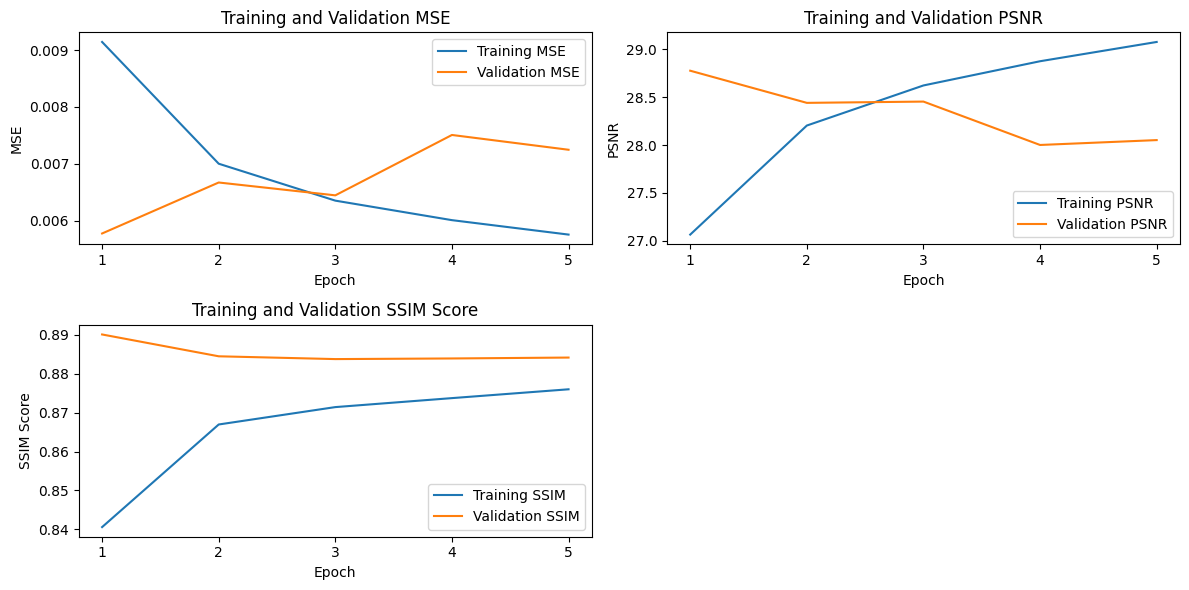

In [19]:
plot_training_metrics('/kaggle/input/csv-data')

In [22]:
volumes = load_and_filter_volumes('/kaggle/input/mmmai-regist-data/MR-ART-Regist')
volumes.sort()

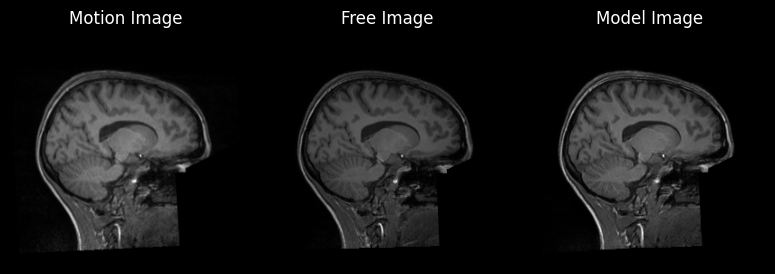

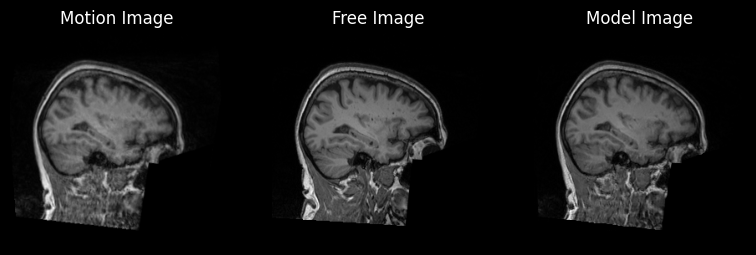

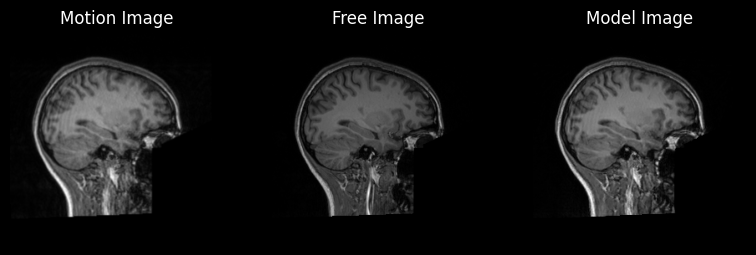

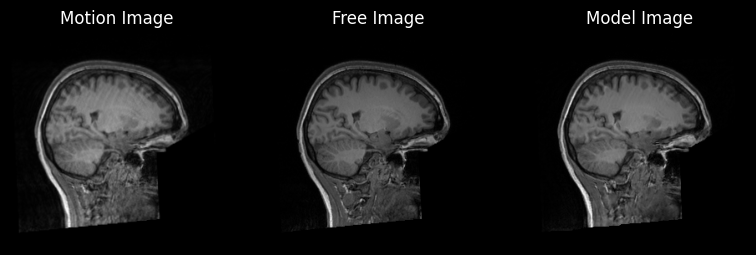

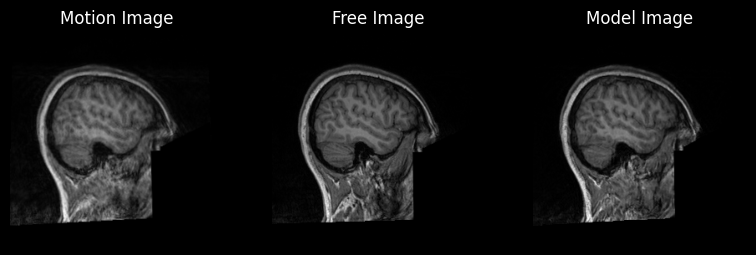

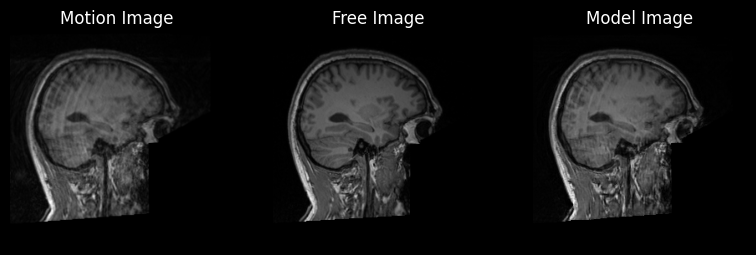

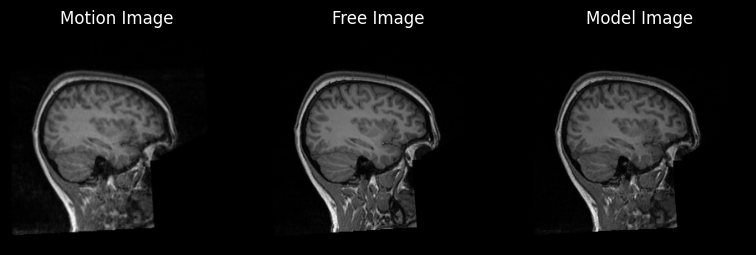

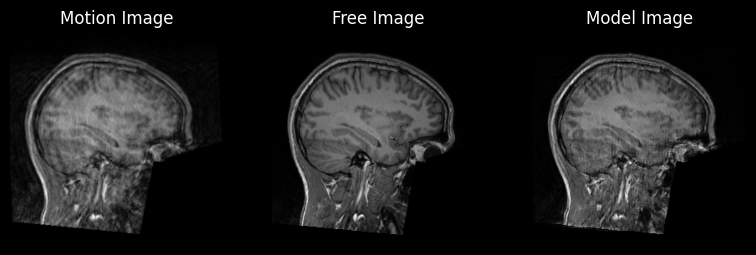

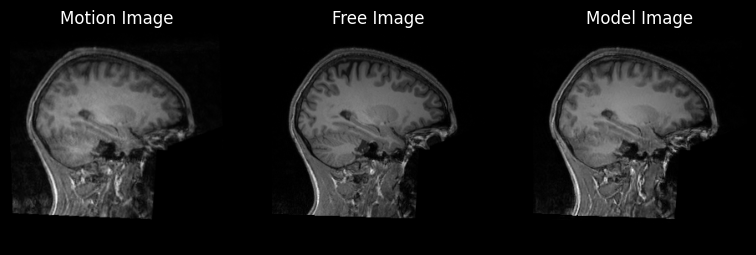

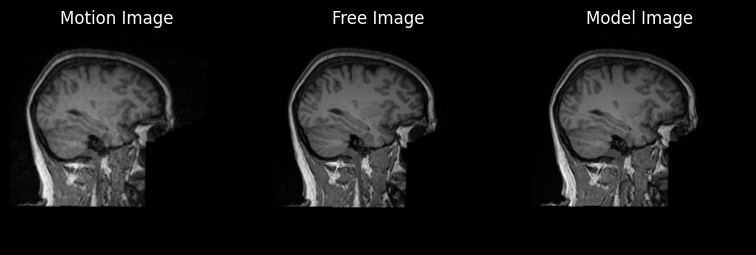

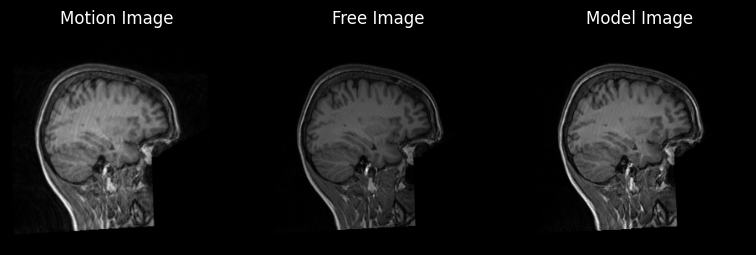

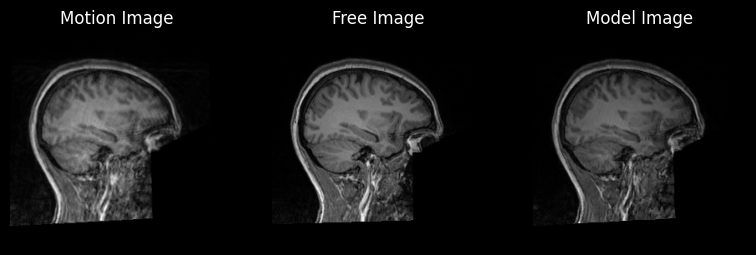

In [23]:
plot_samples(volumes,'/kaggle/input/modelunit/gen_00000008.pt' , 12, norm=False)

In [48]:
def ssim_score(y_true, y_pred):
    score = tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))
    return score

def ssim_loss(y_true, y_pred):
    loss_ssim = 1.0 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))
    return loss_ssim
def l1_loss(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))
def l2_loss(y_true, y_pred):
    """
    Computes the L2 loss between the ground truth and predicted tensors.

    Parameters:
        y_true (tf.Tensor): Ground truth tensor.
        y_pred (tf.Tensor): Predicted tensor.

    Returns:
        tf.Tensor: Normalized L2 loss.

    This function calculates the mean squared error (MSE) between the ground truth
    and predicted tensors. It then reduces the MSE along the spatial dimensions,
    typically representing the height and width of the tensors, resulting in a
    tensor of shape (batch_size,), where each element represents the mean MSE
    for a single sample in the batch.

    The loss is then normalized using L2 normalization to ensure that it falls
    within the range of 0 to 1. Finally, the mean of the normalized loss across
    the batch is computed and returned.
    """
    mse = tf.keras.losses.mean_squared_error(y_true, y_pred)

    # Reduce on spatial information
    batch_mse = tf.reduce_mean(mse, axis=(1, 2))

    # Normalize the loss function to be between 0 and 1
    normalized_loss = tf.nn.l2_normalize(batch_mse, axis=-1)
    
    # Compute the mean of the normalized loss across the batch
    normalized_reduced_loss = tf.reduce_mean(batch_mse)

    return normalized_reduced_loss
def psnr(y_true, y_pred):
    return tf.reduce_mean(-tf.image.psnr(y_true, y_pred, max_val=2.0))

In [42]:
import torch
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms as transforms
import gc
from skimage.metrics import structural_similarity as ssim
def get_test(model_path, dataset):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Clear cache and run garbage collection
    torch.cuda.empty_cache()
    gc.collect()

    # Initialize your model (UNIT_Trainer) with the given configuration
    model = UNIT_Trainer(config)
    
    # Limit GPU memory usage (set to 50% of the total memory)
    torch.cuda.set_per_process_memory_fraction(0.5, 0)

    # Load the checkpoint from the specified path
    checkpoint = torch.load(model_path, map_location=device)
    
    # Extract the generator state dictionaries from the checkpoint
    gen_a = checkpoint['a']
    gen_b = checkpoint['b']

    # Load the state dictionaries into the model's generators
    model.gen_a.load_state_dict(gen_a)
    model.gen_b.load_state_dict(gen_b)

    # Move the model to the appropriate device
    model.to(device)

    # Set the model to evaluation mode
    model.eval()

    print(f'Testing')

    ssim_scores, pnsr_values, l2_losses = [], [], []

    for step, (Slice, FreeImage) in enumerate(dataset):
        if Slice is None or Slice.shape[1] == 0:
            continue

        with torch.no_grad():
            Slice = torch.tensor(Slice, device=device).float()
            output,_ = model.gen_a.encode(Slice)
            output1 = model.gen_b.decode(output)
            output1 = output1.detach().cpu().numpy()
            FreeImage = FreeImage.detach().cpu().numpy()
#             y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
#     y_pred = tf.convert_to_tensor(y_pred, dtype=tf.float32)
            ssim_scores.append(ssim_score(tf.convert_to_tensor(FreeImage), tf.convert_to_tensor(output)))
            pnsr_values.append(psnr(FreeImage, output1))
            l2_losses.append(l2_loss(FreeImage, output1))

    avg_ssim_score = sum(ssim_scores) / len(ssim_scores) if ssim_scores else 0.0
    avg_psnr = sum(pnsr_values) / len(pnsr_values) if pnsr_values else 0.0
    avg_l2_loss = sum(l2_losses) / len(l2_losses) if l2_losses else 0.0

    print(f'Avg_SSIM_Score: {avg_ssim_score:.4f}, Avg_PSNR: {avg_psnr:.4f}, Avg_L2_Loss: {avg_l2_loss:.4f}')

    return avg_ssim_score, avg_psnr, avg_l2_loss


In [49]:
def get_test(model_path, dataset):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Clear cache and run garbage collection
    torch.cuda.empty_cache()
    gc.collect()

    # Initialize your model (UNIT_Trainer) with the given configuration
    model = UNIT_Trainer(config)
    
    # Limit GPU memory usage (set to 50% of the total memory)
    torch.cuda.set_per_process_memory_fraction(0.5, 0)

    # Load the checkpoint from the specified path
    checkpoint = torch.load(model_path, map_location=device)
    
    # Extract the generator state dictionaries from the checkpoint
    gen_a = checkpoint['a']
    gen_b = checkpoint['b']

    # Load the state dictionaries into the model's generators
    model.gen_a.load_state_dict(gen_a)
    model.gen_b.load_state_dict(gen_b)

    # Move the model to the appropriate device
    model.to(device)

    # Set the model to evaluation mode
    model.eval()

    print('Testing')

    ssim_scores, psnr_values, l2_losses = [], [], []

    for step, (Slice, FreeImage) in enumerate(dataset):
        if Slice is None or Slice.shape[1] == 0:
            continue

        with torch.no_grad():
            Slice = Slice.clone().detach().to(device).float()
            output, _ = model.gen_a.encode(Slice)
            output1 = model.gen_b.decode(output)
            output1 = output1.detach().cpu().numpy()
            FreeImage = FreeImage.detach().cpu().numpy()
            output1 = output1.reshape(1,256,256,1)
            FreeImage = FreeImage.reshape(1,256,256,1)
            
            # Convert NumPy arrays to TensorFlow tensors
            FreeImage_tf = tf.convert_to_tensor(FreeImage, dtype=tf.float32)
            output1_tf = tf.convert_to_tensor(output1, dtype=tf.float32)

            # Calculate SSIM, PSNR, and L2 loss
            ssim_scores.append(ssim_score(FreeImage_tf, output1_tf))
            psnr_values.append(psnr(FreeImage_tf, output1_tf))
            l2_losses.append(l2_loss(FreeImage_tf, output1_tf))

    avg_ssim_score = sum(ssim_scores) / len(ssim_scores) if ssim_scores else 0.0
    avg_psnr = sum(psnr_values) / len(psnr_values) if psnr_values else 0.0
    avg_l2_loss = sum(l2_losses) / len(l2_losses) if l2_losses else 0.0

    print(f'Avg_SSIM_Score: {avg_ssim_score:.4f}, Avg_PSNR: {avg_psnr:.4f}, Avg_L2_Loss: {avg_l2_loss:.4f}')

    return avg_ssim_score, avg_psnr, avg_l2_loss


In [50]:
get_test('/kaggle/input/modelunit/gen_00000008.pt',test_dataloader)

Testing


AttributeError: module 'keras._tf_keras.keras.losses' has no attribute 'mean_squared_error'